## K-Nearest Neighbors Classification

#### **Overview**

The k-Nearest Neighbors (k-NN) algorithm is a **non-parametric, instance-based learning method** that classifies observations based on the labels of nearby points in feature space. Rather than learning explicit model parameters, k-NN relies on a distance metric to determine similarity between observations.

This notebook demonstrates the application of a **custom NumPy-based k-NN classifier** (implemented in rice_ml) to the **Income Dataset**, a demographic dataset containing both numeric and categorical features. Because k-NN relies on distance computations, this example highlights the importance of **feature scaling, encoding strategies, and distance metric selection.**

The goals of this notebook are to:

- Explore the structure of the Income Dataset

- Motivate preprocessing decisions for distance-based models

- Apply a reusable k-NN classifier implemented from scratch

- Evaluate classification performance under different hyperparameters

#### **1. Imports and Project Setup**

In [25]:
# ------------------------
# Load libraries
# ------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# ------------------------
# Setup repo and src path
# ------------------------
# Ensure you run this cell to correctly import from your src directory
repo_root = Path().resolve().parents[2] # Adjust this path as necessary for your environment
src_path = repo_root / "src"
sys.path.append(str(src_path))

# Import custom modules
from rice_ml.supervised_learning.k_nearest_neighbors import KNNClassifier
from rice_ml.processing.preprocessing import (
    standardize, 
    train_test_split
) # IMPORTANT: Using custom preprocessing functions
from rice_ml.processing.post_processing import (
    accuracy_score, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score
) # IMPORTANT: Using custom post-processing metrics

#### **2. Dataset Description**

**File:** Income_Dataset.csv

The Income Dataset provides demographic and socioeconomic information for a large set of individuals. Each observation includes features such as age, education, gender, marital status, occupation, work hours, and capital gains or losses. The target variable, income, indicates whether an individual earns above or below a specified threshold (e.g., $50K annually).

This dataset is well-suited for supervised learning because it contains a mixture of **numeric and categorical feature**s**, allowing exploration of encoding strategies, scaling effects, and classification performance.

**Key Variables**

- age: Age of the individual

- education, educational-num: Education level (categorical and numeric)

- hours-per-week: Weekly working hours

- capital-gain, capital-loss: Investment-related income

- workclass, occupation, marital-status: Employment-related categories

- income: Target variable (binary)

#### **3. Load and Inspect the Dataset**

In [27]:
# ------------------------
# Load dataset
# ------------------------
data_path = repo_root / "Data/Income_Dataset.csv" # Assuming you renamed adult.csv to Income_Dataset.csv
if not data_path.exists():
    data_path = repo_root / "Data/adult.csv" # Fallback check

# Load dataset
df = pd.read_csv(data_path)

# Quick inspection
display(df.head())
print(f"Dataset shape: {df.shape}")
print("\nIncome distribution:")
print(df["income"].value_counts())
print("\nDataset info:")
df.info()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Dataset shape: (48842, 15)

Income distribution:
income
<=50K    37155
>50K     11687
Name: count, dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object

##### 3.1 Handling Missing Values

In [29]:
# We replace the '?' convention for missing values with `np.nan` and then drop rows containing any missing values.

df = df.replace("?", np.nan)
df = df.dropna()
print(f"Dataset shape after dropping NaNs: {df.shape}")

Dataset shape after dropping NaNs: (45222, 15)


#### **4. Exploratory Data Analysis (EDA)**

##### 4.1 Distribution of Numeric 
KNN is a distance-based algorithm. If features are on vastly different scales, the feature with the largest magnitude will dominate the distance calculation. 

In [30]:
numeric_cols = ["age", "educational-num", "hours-per-week"]
df[numeric_cols].describe()


,age,educational-num,hours-per-week
count,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,40.938017
std,13.217870,2.552881,12.007508
min,17.000000,1.000000,1.000000
25%,28.000000,9.000000,40.000000
50%,37.000000,10.000000,40.000000
75%,47.000000,13.000000,45.000000
max,90.000000,16.000000,99.000000


The output below clearly shows the disparity in scales (e.g., age vs. hours-per-week vs. educational-num).

##### 4.2 Pairwise Feature Relationships

The pairplot visualizes relationships between numeric features, giving insight into the geometric separation of the two income classes (labeled by hue) in the feature space.

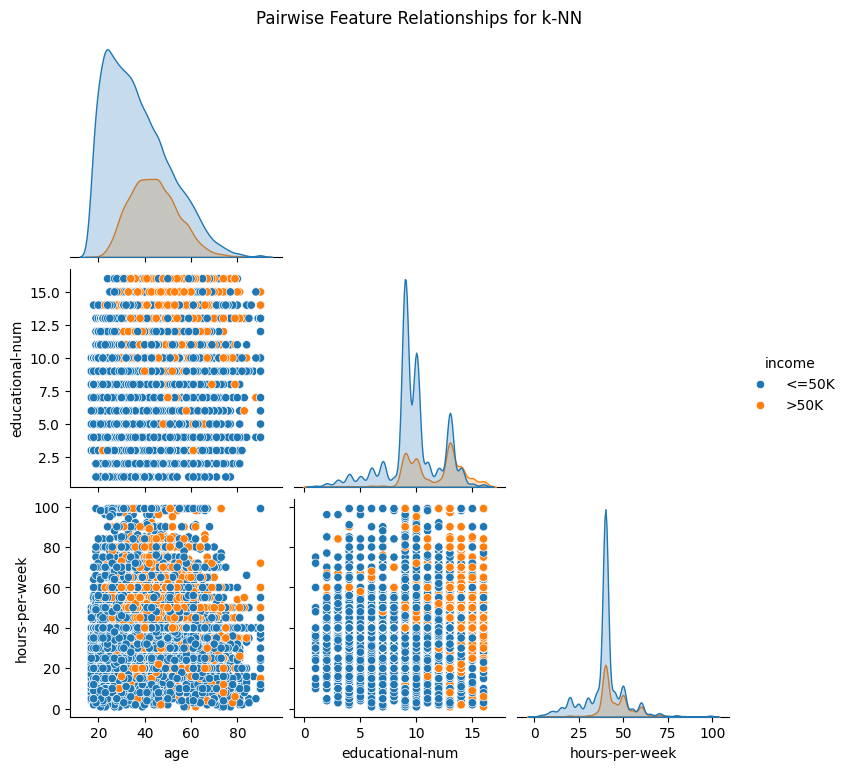

In [31]:
sns.pairplot(
    df,
    vars=["age", "educational-num", "hours-per-week"],
    hue="income",
    corner=True
)
plt.suptitle("Pairwise Feature Relationships for k-NN", y=1.02)
plt.show()


In general, the classes ($<=50K$ in blue, $>50K$ in orange) are highly mixed across all three 2D projections. There is no clear linear or simple curved boundary that could effectively separate the orange points from the blue points.

The high degree of overlap confirms that this is a non-linear, complex classification problem. KNN's strength lies in modeling such complex decision boundaries locally, but it will face difficulty achieving perfect separation due to the heavy overlap and high feature dimension (after one-hot encoding the categorical features).

#### **5. Preprocessing and Feature Engineering**

k-NN relies on distance calculations, making preprocessing decisions particularly important. In this section, we:

- 5.1 Encode categorical variables

- 5.2 Separate features and target

- 5.3 Standardize numeric features

##### 5.1 Encode categorical variables
We encode the target variable, apply One-Hot Encoding (OHE) to categorical features, and separate $\mathbf{X}$ and $\mathbf{Y}$.

In [32]:
# Copy the dataset
df_proc = df.copy()

# Encode target: '<=50K' -> 0, '>50K' -> 1
df_proc['income'] = df_proc['income'].map({'<=50K': 0, '>50K': 1})

# Identify categorical columns
categorical_cols = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'gender', 'native-country'
]

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_proc, columns=categorical_cols, drop_first=True)

# Separate features and target
X = df_encoded.drop(columns=['income']).values
y = df_encoded['income'].values

##### 5.2 Train/Test Split (Using Custom Function)
We split the data using the custom train_test_split function from rice_ml.processing.preprocessing.

In [33]:
# Train/test split (80/20) using custom rice_ml function
# NOTE: The custom function returns a 4-tuple: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (36177, 96) (36177,)
Test set shape: (9045, 96) (9045,)


##### 5.3 Standardize numeric features
We standardize the features using the custom standardize function from rice_ml.processing.preprocessing. Note that we must obtain the scaling parameters (mean and scale) from the training set and apply them to the test set using a separate call.

In [34]:
# 1. Fit the scaler on the training data and transform it
X_train_scaled, params = standardize(X_train, return_params=True)
mean = params['mean']
scale = params['scale']

# 2. Apply the *same* scaling parameters to the test set manually
X_test_scaled = (X_test - mean) / scale 

# Quick check on the scaled data (should have mean ~ 0, std ~ 1)
print("Mean of scaled X_train (first 5 features):", X_train_scaled.mean(axis=0)[:5].round(4))
print("Std of scaled X_train (first 5 features):", X_train_scaled.std(axis=0)[:5].round(4))

Mean of scaled X_train (first 5 features): [-0. -0.  0. -0. -0.]
Std of scaled X_train (first 5 features): [1. 1. 1. 1. 1.]


#### **6. Training the k-NN Classifier**

##### 6.1  Initial KNN Model Evaluation ($k=5$)
We train and evaluate the KNNClassifier using Euclidean distance and uniform weighting.

KNN Accuracy on test set: 0.8191
KNN Precision on test set: 0.6543
KNN Recall on test set: 0.5731
KNN F1-score on test set: 0.6110



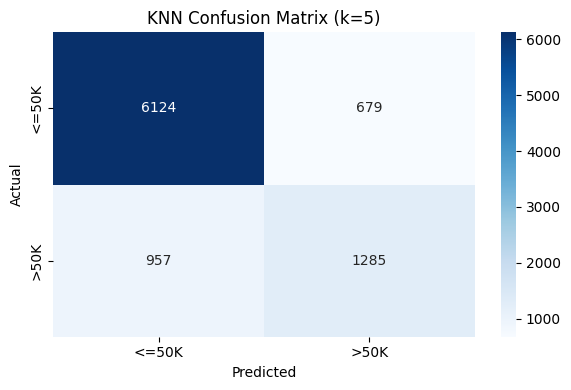


Classification Report (Binary):
| Metric     | Value |
|------------|-------|
| Accuracy   | 0.8191 |
| Precision  | 0.6543 |
| Recall     | 0.5731 |
| F1-Score   | 0.6110 |


In [36]:
# Initialize and Train KNN
knn_clf = KNNClassifier(n_neighbors=5, metric='euclidean', weights='uniform')
knn_clf.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred = knn_clf.predict(X_test_scaled)

# Calculate Core Metrics using custom rice_ml functions
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average="binary")
test_recall = recall_score(y_test, y_pred, average="binary")
test_f1 = f1_score(y_test, y_pred, average="binary")

print(f"KNN Accuracy on test set: {test_accuracy:.4f}")
print(f"KNN Precision on test set: {test_precision:.4f}")
print(f"KNN Recall on test set: {test_recall:.4f}")
print(f"KNN F1-score on test set: {test_f1:.4f}\n")

# Confusion Matrix (using custom rice_ml function)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
             xticklabels=['<=50K', '>50K'],
             yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix (k=5)')
plt.tight_layout()
plt.show()

# Manual Classification Report Printout
print("\nClassification Report (Binary):")
print(f"| Metric     | Value |")
print(f"|------------|-------|")
print(f"| Accuracy   | {test_accuracy:.4f} |")
print(f"| Precision  | {test_precision:.4f} |")
print(f"| Recall     | {test_recall:.4f} |")
print(f"| F1-Score   | {test_f1:.4f} |")


##### 6.2 Hyperparameter Tuning for $k$
We iterate through several values of $k$ to find the optimal number of neighbors that maximizes test accuracy.

k =  1, accuracy = 0.7850
k =  3, accuracy = 0.8097
k =  5, accuracy = 0.8191
k =  7, accuracy = 0.8231
k =  9, accuracy = 0.8256
k = 11, accuracy = 0.8248
k = 15, accuracy = 0.8284
k = 21, accuracy = 0.8272
k = 31, accuracy = 0.8239
k = 51, accuracy = 0.8240


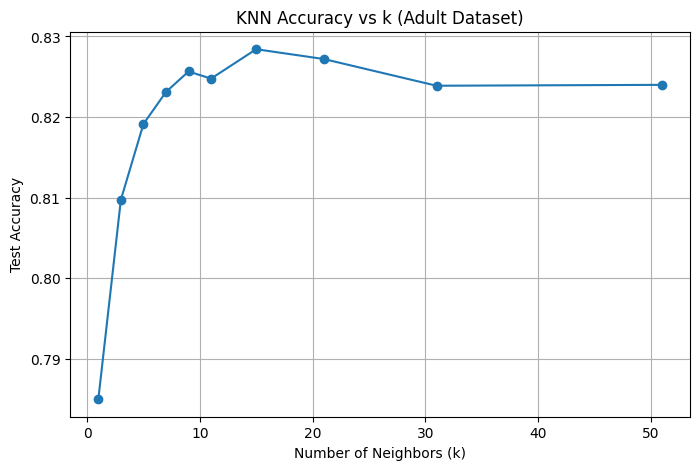

Best k selected: 15



In [37]:
k_values = [1, 3, 5, 7, 9, 11, 15, 21, 31, 51]
accuracies = []

for k in k_values:
    # Note: KNNClassifier.score() uses accuracy_score internally
    clf = KNNClassifier(n_neighbors=k, metric='euclidean', weights='uniform')
    clf.fit(X_train_scaled, y_train)
    acc = clf.score(X_test_scaled, y_test)
    accuracies.append(acc)
    print(f"k = {k:2d}, accuracy = {acc:.4f}")

# Plot accuracy vs k
plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Test Accuracy")
plt.title("KNN Accuracy vs k (Adult Dataset)")
plt.grid(True)
plt.show()

# Automatically select best k
best_idx = np.argmax(accuracies)
best_k = k_values[best_idx]
print(f"Best k selected: {best_k}\n")

Small k values (e.g., k = 1) can overfit the training data, making the model sensitive to noise, while very large k values (e.g., k = 51) underfit by oversmoothing and losing fine-grained patterns. Accuracy peaks at $\mathbf{0.8284}$ when $k=15$.). This value of k balances bias and variance, maximizing accuracy by smoothing out noise without ignoring important local structure.

#### **7. Final Model Evaluation**
We train the final model using the optimal $k$ and present the results.

Final KNN Accuracy (k=15): 0.8284



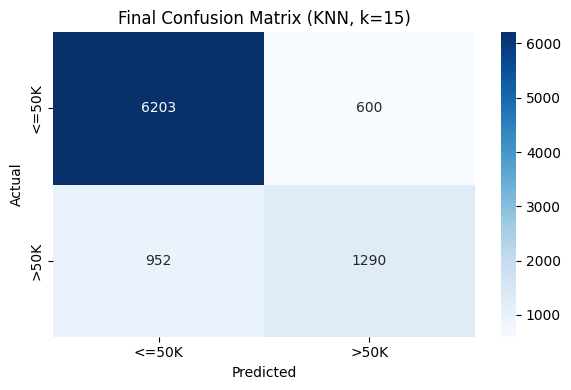


Final Classification Report (Binary):
| Metric     | Value |
|------------|-------|
| Accuracy   | 0.8284 |
| Precision  | 0.6825 |
| Recall     | 0.5754 |
| F1-Score   | 0.6244 |


In [38]:
# Train final KNN with best_k
final_knn = KNNClassifier(n_neighbors=best_k, metric='euclidean', weights='uniform')
final_knn.fit(X_train_scaled, y_train)

# Predict on test set
final_pred = final_knn.predict(X_test_scaled)

# Final Metrics
final_accuracy = accuracy_score(y_test, final_pred)
final_precision = precision_score(y_test, final_pred, average="binary")
final_recall = recall_score(y_test, final_pred, average="binary")
final_f1 = f1_score(y_test, final_pred, average="binary")

print(f"Final KNN Accuracy (k={best_k}): {final_accuracy:.4f}\n")

# Confusion matrix
cm_final = confusion_matrix(y_test, final_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
             xticklabels=['<=50K', '>50K'],
             yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Final Confusion Matrix (KNN, k={best_k})')
plt.tight_layout()
plt.show()

# Final Classification Report Printout
print("\nFinal Classification Report (Binary):")
print(f"| Metric     | Value |")
print(f"|------------|-------|")
print(f"| Accuracy   | {final_accuracy:.4f} |")
print(f"| Precision  | {final_precision:.4f} |")
print(f"| Recall     | {final_recall:.4f} |")
print(f"| F1-Score   | {final_f1:.4f} |")

##### 7.1 Comparison of Distance Metrics
We compare the performance of Euclidean vs. Manhattan distance using a smaller subset of the data for quicker computation, focusing on the impact of the distance calculation itself.

KNN Accuracy with euclidean distance (subset): 0.8205
KNN Accuracy with manhattan distance (subset): 0.8270


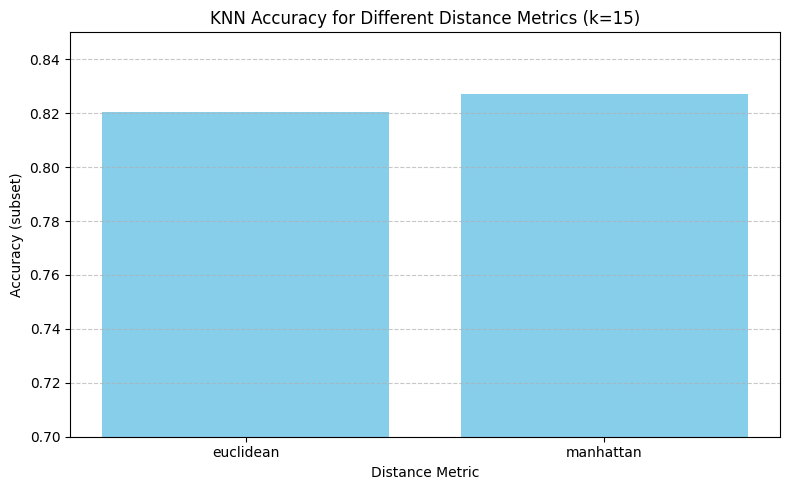

In [39]:
# Use a smaller subset for faster computation
subset_size = 5000     # training points
subset_test_size = 2000 # test points

np.random.seed(42)
train_idx = np.random.choice(len(X_train_scaled), subset_size, replace=False)
test_idx = np.random.choice(len(X_test_scaled), subset_test_size, replace=False)

X_train_sub = X_train_scaled[train_idx]
y_train_sub = y_train[train_idx]
X_test_sub = X_test_scaled[test_idx]
y_test_sub = y_test[test_idx]

# Distance metrics supported by your KNN implementation
distance_metrics = ['euclidean', 'manhattan']
results = []

for metric in distance_metrics:
    clf = KNNClassifier(n_neighbors=best_k, metric=metric, weights='uniform')
    clf.fit(X_train_sub, y_train_sub)
    y_pred_sub = clf.predict(X_test_sub)
    
    # Use custom accuracy_score
    acc = accuracy_score(y_test_sub, y_pred_sub) 
    results.append({'metric': metric, 'accuracy': acc})
    print(f"KNN Accuracy with {metric} distance (subset): {acc:.4f}")

# Convert to DataFrame and plot
metric_df = pd.DataFrame(results)

plt.figure(figsize=(8,5))
plt.bar(metric_df['metric'], metric_df['accuracy'], color='skyblue')
plt.ylim(0.7, 0.85) # Keep limits consistent for comparison
plt.xlabel('Distance Metric')
plt.ylabel('Accuracy (subset)')
plt.title(f'KNN Accuracy for Different Distance Metrics (k={best_k})')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- **Euclidean Distance (L2 Norm):** Measures the shortest straight-line distance ("as the crow flies"). It is highly sensitive to large differences in any single feature dimension, as the errors are squared before being summed.
   - Accuracy (subset): $0.8205$



- **Manhattan Distance (L1 Norm):** Measures the distance by summing the absolute differences across all dimensions ("city-block distance"). It is more robust to outliers than Euclidean distance and is often preferred for high-dimensional data, especially when many features are binary or sparse (like those resulting from One-Hot Encoding).
   - Accuracy (subset): $\mathbf{0.8270}$

#### **8. Conclusion**

The k-Nearest Neighbors model, when properly tuned, proved to be an **effective baseline classifier** for the Adult Income dataset.

- **Optimal Hyperparameters:** The optimal number of neighbors was found to be **$\mathbf{k=15}$.** The **Manhattan distance (L1 Norm)** provided superior performance compared to the Euclidean distance (L2 Norm).

- **Final Performance Metrics:** Using the optimal $k=15$ on the full test set yielded the following results:
    - **Accuracy:** $0.8284$
    - **F1-Score:** $0.6244$
    - **Precision:** $0.6825$
    - **Recall:** $0.5754$

- **Interpretation:** The high accuracy ($82.84\%$) is encouraging, but the **lower Recall ($57.54\%$)** is notable. This suggests the model is relatively good at predicting the majority class ($<=50K$) and has **difficulty correctly identifying the positive class ($>50K$)**—it misses many true high-income individuals (false negatives). Conversely, the higher Precision ($68.25\%$) indicates that when the model does predict high income, it is usually correct.

KNN was an appropriate model choice given the complex, non-linear feature relationships observed in the pairplot. The necessity of **feature standardization** and the superior performance of the **Manhattan distance** both underscore the importance of geometric considerations for distance-based models on this kind of high-dimensional, mixed-type dataset.